# UAH-DriveSet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wandb
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from pprint import pprint

In [ ]:
def getData(driver):
    
    return df

In [7]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

In [8]:
data = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(data)):
    data[i] = data[i].drop(cols, axis=1, inplace=False)

Plotting different sensors to see the difference

In [9]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not 'sem_evento'
    highlight_color = 'lightgrey'  # Use the same color for all events

    for i in range(len(data) - 1):
        if data['evento'].iloc[i] != 'sem_evento':
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], 
                        alpha=0.3, color=highlight_color, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()


/tmp/ipykernel_9803/1071966741.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1],


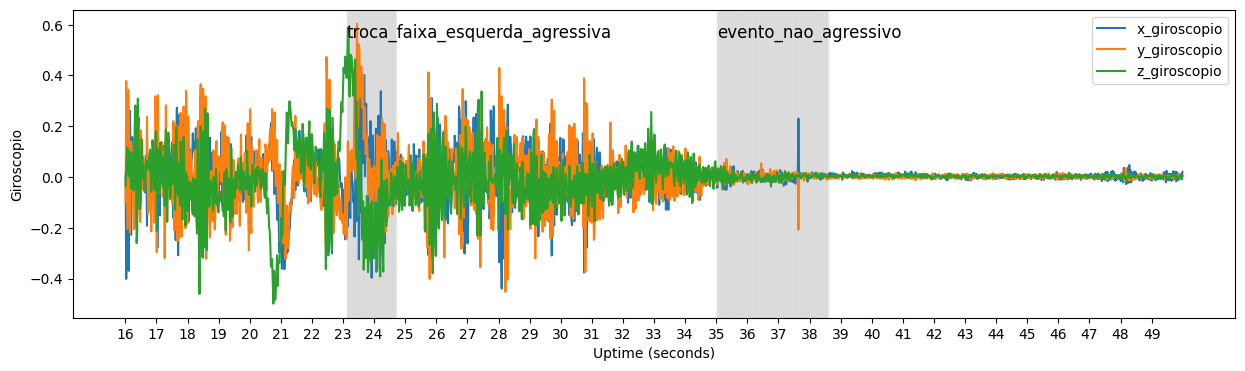

In [13]:
plot_sensor_data(df_21, 'giroscopio', figsize=(15, 4), begin=16, end=50)

### Sliding Windows

In [14]:
def get_features(window):
    # Features such as mean, max, min and std from the window
    features = np.array([])
    features = np.append(features, [window.mean(), window.max(), window.min(), window.std(), window.max() - window.min()])
    return features

In [15]:
def create_sliding_windows(data, window_size=7, step_size=1, output_3d=False):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array

    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns

            if not output_3d:
                features = get_features(window)

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order


            if not output_3d:
                window = np.append(window.to_numpy().flatten(), features)
            else:
                window = np.array(window)
            
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [16]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [17]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test  

In [18]:
def encode(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    return y

In [19]:
window_size = 7
step_size = 1
X, y = create_sliding_windows(data, window_size, step_size) # This will create the sliding windows with a 2D X and 1D y
X.shape, y.shape

((10663, 108), (10663,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Since we already have windows with labels, we can split the data into train and test sets

In [21]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [22]:
classes = np.unique(y_train)
one_hot = {}
for i in range(len(classes)):
    one_hot[classes[i]] = i
y_train_one_hot = np.array([one_hot[i] for i in y_train])
y_test_one_hot = np.array([one_hot[i] for i in y_test])
one_hot

{np.str_('aceleracao_agressiva'): 0,
 np.str_('curva_direita_agressiva'): 1,
 np.str_('curva_esquerda_agressiva'): 2,
 np.str_('evento_nao_agressivo'): 3,
 np.str_('freada_agressiva'): 4,
 np.str_('troca_faixa_direita_agressiva'): 5,
 np.str_('troca_faixa_esquerda_agressiva'): 6}

Veryfing the balance of the split

In [23]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))

Train set: {np.str_('aceleracao_agressiva'): np.int64(1716), np.str_('curva_direita_agressiva'): np.int64(1495), np.str_('curva_esquerda_agressiva'): np.int64(1515), np.str_('evento_nao_agressivo'): np.int64(1964), np.str_('freada_agressiva'): np.int64(1081), np.str_('troca_faixa_direita_agressiva'): np.int64(440), np.str_('troca_faixa_esquerda_agressiva'): np.int64(319)}
Test set: {np.str_('aceleracao_agressiva'): np.int64(414), np.str_('curva_direita_agressiva'): np.int64(387), np.str_('curva_esquerda_agressiva'): np.int64(365), np.str_('evento_nao_agressivo'): np.int64(480), np.str_('freada_agressiva'): np.int64(309), np.str_('troca_faixa_direita_agressiva'): np.int64(94), np.str_('troca_faixa_esquerda_agressiva'): np.int64(84)}


# Machine Learning

In [24]:
def kfold_cross_validation_ML(model_function, X, y, params, n_splits=10):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kf.split(X):
        print(f'Fold {len(accuracies) + 1}')
        X_train_fold, X_val_fold = X[train_index], X[test_index]
        y_train_fold, y_val_fold = y[train_index], y[test_index]

        X_train_fold_scaled, X_test_fold_scaled = scale_data(X_train_fold.reshape(X_train_fold.shape[0], -1), X_val_fold.reshape(X_val_fold.shape[0], -1))
        X_train_fold_scaled = X_train_fold_scaled.reshape(X_train_fold.shape)
        X_val_fold_scaled = X_test_fold_scaled.reshape(X_val_fold.shape)

        model = model_function(**params)
        model.fit(X_train_fold_scaled, y_train_fold)
        y_predict = model.predict(X_val_fold_scaled)
        acc = accuracy_score(y_val_fold, y_predict)
        prec = precision_score(y_val_fold, y_predict, average='weighted')
        rec = recall_score(y_val_fold, y_predict, average='weighted')
        
        print(f'\tValidation accuracy: {acc}')
        print(f'\tValidation precision: {prec}')
        print(f'\tValidation recall: {rec}')
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)

    report = {}
    report['accuracy'] = {'mean': np.mean(accuracies), 'min': np.min(accuracies), 'max': np.max(accuracies)}
    report['precision'] = {'mean': np.mean(precisions), 'min': np.min(precisions), 'max': np.max(precisions)}
    report['recall'] = {'mean': np.mean(recalls), 'min': np.min(recalls), 'max': np.max(recalls)}

    return report, y_predict, y_val_fold

In [25]:
reports = {}

## Random Forest Classifier

In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, verbose=5, n_jobs=-1)
best_params_rf = grid_search.fit(X_train_scaled, y_train).best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END ..................n_estimators=100;, score=0.953 total time=  10.0s
[CV 3/5] END ..................n_estimators=100;, score=0.949 total time=  12.0s
[CV 4/5] END ..................n_estimators=100;, score=0.943 total time=  12.3s
[CV 1/5] END ..................n_estimators=100;, score=0.937 total time=  12.4s
[CV 5/5] END ..................n_estimators=100;, score=0.954 total time=  12.6s
[CV 1/5] END ..................n_estimators=200;, score=0.940 total time=  25.9s
[CV 2/5] END ..................n_estimators=200;, score=0.953 total time=  25.6s
[CV 4/5] END ..................n_estimators=200;, score=0.944 total time=  25.8s
[CV 5/5] END ..................n_estimators=200;, score=0.958 total time=  27.7s
[CV 3/5] END ..................n_estimators=200;, score=0.951 total time=  28.5s
[CV 2/5] END ..................n_estimators=300;, score=0.955 total time=  33.0s
[CV 1/5] END ..................n_estimators=300;,

In [27]:
report_rf, y_pred_rf, y_val_rf = kfold_cross_validation_ML(RandomForestClassifier, X, y, {'n_estimators': 300}, n_splits=10)

Fold 1
	Validation accuracy: 0.9615745079662605
	Validation precision: 0.9629605304689435
	Validation recall: 0.9615745079662605
Fold 2
	Validation accuracy: 0.9662605435801312
	Validation precision: 0.9670327133860731
	Validation recall: 0.9662605435801312
Fold 3
	Validation accuracy: 0.9587628865979382
	Validation precision: 0.9604053946525121
	Validation recall: 0.9587628865979382
Fold 4
	Validation accuracy: 0.9540337711069419
	Validation precision: 0.9551299228085554
	Validation recall: 0.9540337711069419
Fold 5
	Validation accuracy: 0.9671669793621013
	Validation precision: 0.967597693655579
	Validation recall: 0.9671669793621013
Fold 6
	Validation accuracy: 0.9512195121951219
	Validation precision: 0.951756657517953
	Validation recall: 0.9512195121951219
Fold 7
	Validation accuracy: 0.9652908067542214
	Validation precision: 0.9660254866786683
	Validation recall: 0.9652908067542214
Fold 8
	Validation accuracy: 0.949343339587242
	Validation precision: 0.9497034798214126
	Validatio

In [28]:
reports['RandomForest'] = report_rf
pprint(report_rf)

{'accuracy': {'max': np.float64(0.9671669793621013),
              'mean': np.float64(0.9596729270226882),
              'min': np.float64(0.949343339587242)},
 'precision': {'max': np.float64(0.967597693655579),
               'mean': np.float64(0.9606371927915278),
               'min': np.float64(0.9497034798214126)},
 'recall': {'max': np.float64(0.9671669793621013),
            'mean': np.float64(0.9596729270226882),
            'min': np.float64(0.949343339587242)}}


In [29]:
def display_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

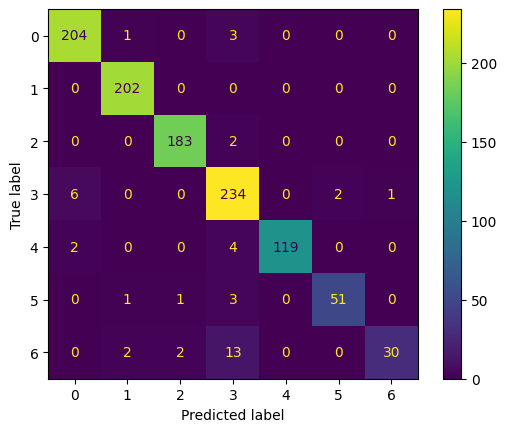

In [30]:
display_cm(y_val_rf, y_pred_rf)

## SVC (Support Vector Classifier)

In [31]:
def fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.1, kernel='rbf'):
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, classification_report(y_test, y_pred), y_pred

Hyperparameter search

In [27]:
param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']} # Defining the hyperparameters to be tested

In [28]:
grid_search = GridSearchCV(SVC(), param_grid, verbose=3, n_jobs=-1) # Creating the GridSearchCV object
grid_search.fit(X_train_scaled, y_train) # Fitting the model
best_params_svc = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   5.8s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.879 total time=   6.5s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.908 total time=   8.3s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.902 total time=  10.1s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.883 total time=  10.6s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.926 total time=  12.5s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.821 total time=  23.7s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.826 total time=  23.9s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.936 total time=  14.9s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.803 total time=  25.7s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.807 total time=  27.8s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;,

In [29]:
print(best_params_svc)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


Best parameters for the SVC are C: 100, gamma: 0.01, kernel: rbf

First, comparing the results of a single model with scaled x non_scaled data

In [ ]:
svc_model, svc_report, y_svc_pred = fit_SVC(X_train_scaled, X_test_scaled, y_train, y_test, C=100, gamma=0.01, kernel='rbf')
print(f"Classification report (SVC scaled):\n{svc_report}")

svc_model_scaled, svc_report_scaled, y_svc_pred_scaled = fit_SVC(X_train, X_test, y_train, y_test, C=100, gamma=0.01, kernel='rbf')
print(f"Classification report (SVC non-scaled):\n{svc_report_scaled}")

Classification report (SVC scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.94      0.94      0.94       414
       curva_direita_agressiva       0.97      1.00      0.98       387
      curva_esquerda_agressiva       0.99      0.98      0.99       365
          evento_nao_agressivo       0.91      0.94      0.92       480
              freada_agressiva       1.00      0.94      0.97       309
 troca_faixa_direita_agressiva       0.98      0.94      0.96        94
troca_faixa_esquerda_agressiva       0.91      0.85      0.88        84

                      accuracy                           0.96      2133
                     macro avg       0.96      0.94      0.95      2133
                  weighted avg       0.96      0.96      0.96      2133

Classification report (SVC non-scaled):
                                precision    recall  f1-score   support

          aceleracao_agressiva       0.89      0.90     

Crearly, scaled data performs better. Let's KFold it

In [33]:
report_svm, y_pred_svm, y_val_svm = kfold_cross_validation_ML(SVC, X, y, {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}, n_splits=10) # The data is being scaled inside the function

Fold 1
	Validation accuracy: 0.9587628865979382
	Validation precision: 0.9605465064745997
	Validation recall: 0.9587628865979382
Fold 2
	Validation accuracy: 0.9662605435801312
	Validation precision: 0.9664861436437913
	Validation recall: 0.9662605435801312
Fold 3
	Validation accuracy: 0.9418931583880038
	Validation precision: 0.9415728180716183
	Validation recall: 0.9418931583880038
Fold 4
	Validation accuracy: 0.9559099437148217
	Validation precision: 0.9562793138157576
	Validation recall: 0.9559099437148217
Fold 5
	Validation accuracy: 0.9530956848030019
	Validation precision: 0.9531729253451204
	Validation recall: 0.9530956848030019
Fold 6
	Validation accuracy: 0.9530956848030019
	Validation precision: 0.9532422510068234
	Validation recall: 0.9530956848030019
Fold 7
	Validation accuracy: 0.948405253283302
	Validation precision: 0.9495668187416458
	Validation recall: 0.948405253283302
Fold 8
	Validation accuracy: 0.9427767354596623
	Validation precision: 0.9422592171709804
	Validati

In [34]:
reports['SVM'] = report_svm
pprint(report_svm)

{'accuracy': {'max': np.float64(0.9662605435801312),
              'mean': np.float64(0.9527329346539807),
              'min': np.float64(0.9418931583880038)},
 'precision': {'max': np.float64(0.9664861436437913),
               'mean': np.float64(0.953086492915207),
               'min': np.float64(0.9415728180716183)},
 'recall': {'max': np.float64(0.9662605435801312),
            'mean': np.float64(0.9527329346539807),
            'min': np.float64(0.9418931583880038)}}


SVC works better with scaled data

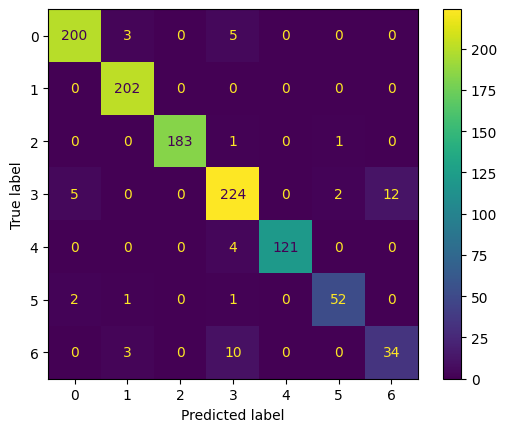

In [35]:
display_cm(y_val_svm, y_pred_svm)


## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5] END ...metric=euclidean, n_neighbors=5;, score=0.918 total time=   0.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=5;, score=0.924 total time=   0.2s
[CV 4/5] END ...metric=euclidean, n_neighbors=3;, score=0.922 total time=   0.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;, score=0.928 total time=   0.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=5;, score=0.910 total time=   0.2s
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.917 total time=   0.4s
[CV 3/5] END ...metric=euclidean, n_neighbors=7;, score=0.913 total time=   0.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=7;, score=0.916 total time=   0.2s
[CV 3/5] END ...metric=euclidean, n_neighbors=3;, score=0.924 total time=   0.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=3;, score=0.918 total time=   0.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=7;, score=0.913 total time=   0.2s
[CV 1/5] END .....metric=manhattan, n_neighbors=3

/home/renan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/renan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/renan/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/renan/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
  File "/home/renan/.local/lib/python3.10/site-packages/sklearn/base.py", line 572, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/renan/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", 

[CV 1/5] END ...metric=euclidean, n_neighbors=9;, score=0.900 total time=   0.3s
[CV 3/5] END ...metric=euclidean, n_neighbors=9;, score=0.909 total time=   0.3s
Fold 1
	Validation accuracy: 0.943767572633552
	Validation precision: 0.946159060368474
	Validation recall: 0.943767572633552
Fold 2
	Validation accuracy: 0.9568884723523898
	Validation precision: 0.9568935174691655
	Validation recall: 0.9568884723523898
Fold 3
	Validation accuracy: 0.9343955014058107
	Validation precision: 0.9355467990892173
	Validation recall: 0.9343955014058107
Fold 4
	Validation accuracy: 0.9277673545966229
	Validation precision: 0.9298892462715912
	Validation recall: 0.9277673545966229
Fold 5
	Validation accuracy: 0.9512195121951219
	Validation precision: 0.9521714724134637
	Validation recall: 0.9512195121951219
Fold 6
	Validation accuracy: 0.948405253283302
	Validation precision: 0.9492624850051925
	Validation recall: 0.948405253283302
Fold 7
	Validation accuracy: 0.9305816135084428
	Validation precision

In [61]:
# Define the parameter grid for kNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}
y_train_encoded = encode(y_train)
# Perform grid search to find the best parameters
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, verbose=3, n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train_encoded)
best_params_knn = grid_search_knn.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5] END ...metric=euclidean, n_neighbors=3;, score=0.924 total time=   0.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=5;, score=0.924 total time=   0.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=7;, score=0.916 total time=   0.2s
[CV 1/5] END ...metric=euclidean, n_neighbors=5;, score=0.915 total time=   0.3s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;, score=0.928 total time=   0.3s
[CV 1/5] END ...metric=euclidean, n_neighbors=7;, score=0.908 total time=   0.3s
[CV 3/5] END ...metric=euclidean, n_neighbors=5;, score=0.918 total time=   0.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=5;, score=0.910 total time=   0.4s
[CV 5/5] END ...metric=euclidean, n_neighbors=3;, score=0.918 total time=   0.4s
[CV 3/5] END ...metric=euclidean, n_neighbors=7;, score=0.913 total time=   0.2s
[CV 4/5] END ...metric=euclidean, n_neighbors=5;, score=0.916 total time=   0.4s
[CV 1/5] END ...metric=euclidean, n_neighbors=3;,

In [64]:
# Perform k-fold cross-validation with the best parameters
y_encoded = encode(y)
report_knn, y_pred_knn, y_val_knn = kfold_cross_validation_ML(KNeighborsClassifier, X, y_encoded, best_params_knn, n_splits=10)
# Store the report in the reports dictionary
reports['kNN'] = report_knn
pprint(report_knn)

Fold 1
	Validation accuracy: 0.9625117150890347
	Validation precision: 0.9638109996134937
	Validation recall: 0.9625117150890347
Fold 2
	Validation accuracy: 0.9803186504217432
	Validation precision: 0.9801514379647767
	Validation recall: 0.9803186504217432
Fold 3
	Validation accuracy: 0.9671977507029054
	Validation precision: 0.9683300645840717
	Validation recall: 0.9671977507029054
Fold 4
	Validation accuracy: 0.9681050656660413
	Validation precision: 0.968536915956827
	Validation recall: 0.9681050656660413
Fold 5
	Validation accuracy: 0.9690431519699813
	Validation precision: 0.9695622293303616
	Validation recall: 0.9690431519699813
Fold 6
	Validation accuracy: 0.9727954971857411
	Validation precision: 0.9731471653461006
	Validation recall: 0.9727954971857411
Fold 7
	Validation accuracy: 0.9652908067542214
	Validation precision: 0.9655343074919178
	Validation recall: 0.9652908067542214
Fold 8
	Validation accuracy: 0.9681050656660413
	Validation precision: 0.9685874957395171
	Validat

## XGBoost

In [36]:
from xgboost import XGBClassifier

In [37]:
y_encoded = encode(y)
report_xgb, y_pred_xgb, y_val_xgb = kfold_cross_validation_ML(XGBClassifier, X, y_encoded, {'n_estimators': 300, 'max_depth': 3}, n_splits=10)

Fold 1
	Validation accuracy: 0.9906279287722587
	Validation precision: 0.9907661099044628
	Validation recall: 0.9906279287722587
Fold 2
	Validation accuracy: 0.985941893158388
	Validation precision: 0.9860233967392074
	Validation recall: 0.985941893158388
Fold 3
	Validation accuracy: 0.985941893158388
	Validation precision: 0.9862398689778507
	Validation recall: 0.985941893158388
Fold 4
	Validation accuracy: 0.9868667917448405
	Validation precision: 0.9870464510088978
	Validation recall: 0.9868667917448405
Fold 5
	Validation accuracy: 0.9868667917448405
	Validation precision: 0.9870708493738837
	Validation recall: 0.9868667917448405
Fold 6
	Validation accuracy: 0.9887429643527205
	Validation precision: 0.9887941233638242
	Validation recall: 0.9887429643527205
Fold 7
	Validation accuracy: 0.9868667917448405
	Validation precision: 0.9870174963731362
	Validation recall: 0.9868667917448405
Fold 8
	Validation accuracy: 0.9840525328330206
	Validation precision: 0.984158338806027
	Validation 

In [38]:
reports['XGB'] = report_xgb
pprint(report_xgb)

{'accuracy': {'max': np.float64(0.9906279287722587),
              'mean': np.float64(0.9863074566871399),
              'min': np.float64(0.9831144465290806)},
 'precision': {'max': np.float64(0.9907661099044628),
               'mean': np.float64(0.9864869598563688),
               'min': np.float64(0.9835541939625888)},
 'recall': {'max': np.float64(0.9906279287722587),
            'mean': np.float64(0.9863074566871399),
            'min': np.float64(0.9831144465290806)}}


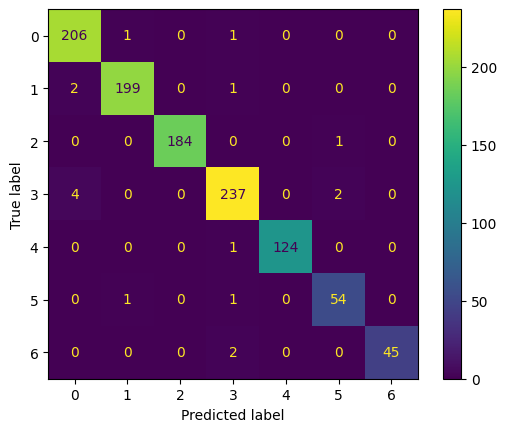

In [39]:
display_cm(y_val_xgb, y_pred_xgb)

# MLP Scikit-Learn

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
report_mlp, y_pred_mlp, y_val_mlp = kfold_cross_validation_ML(MLPClassifier, X, y, {'hidden_layer_sizes': (50, 40, 30), 'max_iter': 1000, 'activation': 'relu', 'solver': 'adam'}, n_splits=10)

Fold 1
	Validation accuracy: 0.9550140581068416
	Validation precision: 0.9551711633736926
	Validation recall: 0.9550140581068416
Fold 2
	Validation accuracy: 0.9681349578256795
	Validation precision: 0.9682283100768592
	Validation recall: 0.9681349578256795
Fold 3
	Validation accuracy: 0.9550140581068416
	Validation precision: 0.9569104633314157
	Validation recall: 0.9550140581068416
Fold 4
	Validation accuracy: 0.9559099437148217
	Validation precision: 0.9563604975712173
	Validation recall: 0.9559099437148217
Fold 5
	Validation accuracy: 0.9596622889305816
	Validation precision: 0.9596838795114294
	Validation recall: 0.9596622889305816
Fold 6
	Validation accuracy: 0.9596622889305816
	Validation precision: 0.9599919485494608
	Validation recall: 0.9596622889305816
Fold 7
	Validation accuracy: 0.9643527204502814
	Validation precision: 0.9646166552631045
	Validation recall: 0.9643527204502814
Fold 8
	Validation accuracy: 0.9409005628517824
	Validation precision: 0.9423646698951279
	Valida

In [43]:
reports['MLP-Scikit'] = report_mlp
pprint(report_mlp)

{'accuracy': {'max': np.float64(0.9681349578256795),
              'mean': np.float64(0.9561089903307656),
              'min': np.float64(0.9409005628517824)},
 'precision': {'max': np.float64(0.9682283100768592),
               'mean': np.float64(0.9566499018873049),
               'min': np.float64(0.9423646698951279)},
 'recall': {'max': np.float64(0.9681349578256795),
            'mean': np.float64(0.9561089903307656),
            'min': np.float64(0.9409005628517824)}}


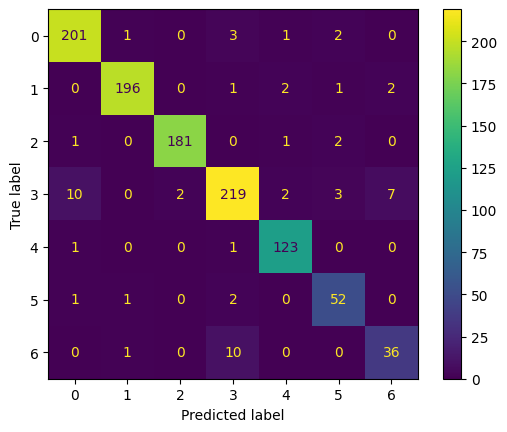

In [44]:
display_cm(y_val_mlp, y_pred_mlp)

# MLP TensorFlow

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, BatchNormalization, LSTM
from tensorflow.keras.utils import to_categorical

2025-02-27 12:06:22.903235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 12:06:22.908488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 12:06:22.978166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 12:06:23.054243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740668783.127066    9803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740668783.14

Using sparse categorial crossentropy since the labels are not one-hot encoded

In [46]:
def kfold_cross_validation_TF(model_func, X, y, params, epochs=50, batch_size=128, n_splits=10):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    precisions = []
    recalls = []
    y = encode(y)

    for train_index, test_index in kf.split(X):
        print(f'Fold {len(accuracies) + 1}')
        X_train_fold, X_val_fold = X[train_index], X[test_index]
        y_train_fold, y_val_fold = y[train_index], y[test_index]

        model = model_func(**params) # This created and compiles the model

        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)
        y_predict = model.predict(X_val_fold)
        y_predict = np.argmax(y_predict, axis=1)
        
        acc = accuracy_score(y_val_fold, y_predict)
        prec = precision_score(y_val_fold, y_predict, average='weighted')
        rec = recall_score(y_val_fold, y_predict, average='weighted')
        
        print(f'\tValidation accuracy: {acc}')
        print(f'\tValidation precision: {prec}')
        print(f'\tValidation recall: {rec}')
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)

    report = {}
    report['accuracy'] = {'mean': np.mean(accuracies), 'min': np.min(accuracies), 'max': np.max(accuracies)}
    report['precision'] = {'mean': np.mean(precisions), 'min': np.min(precisions), 'max': np.max(precisions)}
    report['recall'] = {'mean': np.mean(recalls), 'min': np.min(recalls), 'max': np.max(recalls)}

    return report, y_predict, y_val_fold


In [47]:
def create_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    model =  Sequential([
        # Input is of shape (number_of_features,)
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(50, activation='relu'),

        Dense(40, activation='relu'),

        Dense(30, activation='relu'),

        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [43]:
def train_mlp_wandb():
    wandb.init(project='DriverBehavior')
    epochs = wandb.config.epochs
    batch_size = wandb.config.batch_size

    model = create_model()
    history = model.fit(X_train_scaled, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test_one_hot))

    wandb.log({
        'train_loss': history.history['loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
    })

In [44]:
sweep_config = {
    'method': 'grid',  # 'random' or 'bayes' for other strategies
    'metric': {
        'name': 'val_accuracy',  # The metric to optimize
        'goal': 'maximize'  # Maximize or minimize the metric
    },
    'parameters': {
        'epochs': {
            'values': [10, 25, 50]  # Range of epochs to test
        },
        'batch_size': {
            'values': [32, 64, 128]  # Range of batch sizes to test
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="DriverBehavior")

Create sweep with ID: jed55gi3
Sweep URL: https://wandb.ai/renan-florencio-unicamp/DriverBehavior/sweeps/jed55gi3


In [67]:
wandb.agent(sweep_id, train_mlp_wandb, count=10)

wandb: Agent Starting Run: wa0u51qj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5708 - loss: 1.2386 - val_accuracy: 0.8401 - val_loss: 0.5023
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8150 - loss: 0.5633 - val_accuracy: 0.8790 - val_loss: 0.3666
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8610 - loss: 0.4236 - val_accuracy: 0.8955 - val_loss: 0.3012
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8725 - loss: 0.3591 - val_accuracy: 0.9072 - val_loss: 0.2684
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9073 - loss: 0.2814 - val_accuracy: 0.9198 - val_loss: 0.2360
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9137 - loss: 0.2591 - val_accuracy: 0.9287 - val_loss: 0.2208
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9217 - loss: 0.2276 - val_accuracy: 0.9259 - val_loss: 0.2389
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9198 - loss: 0.2255 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93916
train_loss,0.16933
val_accuracy,0.94374
val_loss,0.18658


wandb: Agent Starting Run: syfu5ppp with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25


Epoch 1/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5613 - loss: 1.2509 - val_accuracy: 0.8242 - val_loss: 0.4856
Epoch 2/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7947 - loss: 0.5854 - val_accuracy: 0.8837 - val_loss: 0.3256
Epoch 3/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8523 - loss: 0.4223 - val_accuracy: 0.9058 - val_loss: 0.2773
Epoch 4/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8811 - loss: 0.3343 - val_accuracy: 0.9147 - val_loss: 0.2575
Epoch 5/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8941 - loss: 0.2991 - val_accuracy: 0.9287 - val_loss: 0.2127
Epoch 6/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9177 - loss: 0.2408 - val_accuracy: 0.9203 - val_loss: 0.2294
Epoch 7/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9186 - loss: 0.2467 - val_accuracy: 0.9405 - val_loss: 0.1954
Epoch 8/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9275 - loss: 0.2100 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97257
train_loss,0.08191
val_accuracy,0.9564
val_loss,0.15545


wandb: Agent Starting Run: 0kvkdc3y with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50


Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5555 - loss: 1.2769 - val_accuracy: 0.8448 - val_loss: 0.4363
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8036 - loss: 0.5645 - val_accuracy: 0.8865 - val_loss: 0.3532
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8524 - loss: 0.4331 - val_accuracy: 0.9095 - val_loss: 0.2760
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8849 - loss: 0.3425 - val_accuracy: 0.9208 - val_loss: 0.2443
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9013 - loss: 0.2916 - val_accuracy: 0.9325 - val_loss: 0.1940
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9119 - loss: 0.2587 - val_accuracy: 0.9339 - val_loss: 0.1879
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9281 - loss: 0.2251 - val_accuracy: 0.9311 - val_loss: 0.2079
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9329 - loss: 0.2002 - val_accuracy: 0.

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.05015
val_accuracy,0.96906
val_loss,0.14908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d08g61w2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5378 - loss: 1.3229 - val_accuracy: 0.8411 - val_loss: 0.4789
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7916 - loss: 0.6135 - val_accuracy: 0.8800 - val_loss: 0.3742
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8456 - loss: 0.4658 - val_accuracy: 0.8940 - val_loss: 0.3051
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8715 - loss: 0.3706 - val_accuracy: 0.9142 - val_loss: 0.2714
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8868 - loss: 0.3160 - val_accuracy: 0.9194 - val_loss: 0.2285
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9072 - loss: 0.2706 - val_accuracy: 0.9264 - val_loss: 0.2345
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9097 - loss: 0.2654 - val_accuracy: 0.9269 - val_loss: 0.2283
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9226 - loss: 0.2317 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.9381
train_loss,0.18065
val_accuracy,0.93812
val_loss,0.20765


wandb: Agent Starting Run: 3znzxxqe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25


Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5303 - loss: 1.3739 - val_accuracy: 0.8284 - val_loss: 0.4927
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7891 - loss: 0.6302 - val_accuracy: 0.8861 - val_loss: 0.3421
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.4627 - val_accuracy: 0.9062 - val_loss: 0.2701
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8704 - loss: 0.3736 - val_accuracy: 0.9128 - val_loss: 0.2540
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8964 - loss: 0.3067 - val_accuracy: 0.9353 - val_loss: 0.2168
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9021 - loss: 0.2856 - val_accuracy: 0.9301 - val_loss: 0.2212
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9150 - loss: 0.2466 - val_accuracy: 0.9344 - val_loss: 0.1897
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9222 - loss: 0.2165 - val_accu

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97304
train_loss,0.08219
val_accuracy,0.95499
val_loss,0.1595


wandb: Agent Starting Run: fp4pjgab with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50


Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5314 - loss: 1.3547 - val_accuracy: 0.8383 - val_loss: 0.4747
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7909 - loss: 0.6286 - val_accuracy: 0.8758 - val_loss: 0.3519
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8467 - loss: 0.4483 - val_accuracy: 0.8987 - val_loss: 0.3067
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8765 - loss: 0.3713 - val_accuracy: 0.9137 - val_loss: 0.2837
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8964 - loss: 0.3163 - val_accuracy: 0.9142 - val_loss: 0.2376
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9013 - loss: 0.2960 - val_accuracy: 0.9241 - val_loss: 0.2351
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9158 - loss: 0.2411 - val_accuracy: 0.9241 - val_loss: 0.2200
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9256 - loss: 0.2233 - val_accur

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98124
train_loss,0.05425
val_accuracy,0.97609
val_loss,0.12793


wandb: Agent Starting Run: x95rt9bq with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4989 - loss: 1.4532 - val_accuracy: 0.8228 - val_loss: 0.5362
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7661 - loss: 0.6764 - val_accuracy: 0.8664 - val_loss: 0.4044
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8208 - loss: 0.5339 - val_accuracy: 0.8823 - val_loss: 0.3463
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8493 - loss: 0.4353 - val_accuracy: 0.9109 - val_loss: 0.2698
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8760 - loss: 0.3587 - val_accuracy: 0.9072 - val_loss: 0.2831
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8983 - loss: 0.3140 - val_accuracy: 0.9297 - val_loss: 0.2236
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9082 - loss: 0.2759 - val_accuracy: 0.9278 - val_loss: 0.2219
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9108 - loss: 0.2623 - val_accuracy: 0.9409 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.93189
train_loss,0.20206
val_accuracy,0.93624
val_loss,0.19907


wandb: Agent Starting Run: huhy15vj with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25


Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4712 - loss: 1.5265 - val_accuracy: 0.7979 - val_loss: 0.5860
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7648 - loss: 0.7112 - val_accuracy: 0.8697 - val_loss: 0.3809
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8106 - loss: 0.5406 - val_accuracy: 0.8973 - val_loss: 0.3127
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8418 - loss: 0.4649 - val_accuracy: 0.9090 - val_loss: 0.2755
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8810 - loss: 0.3447 - val_accuracy: 0.9161 - val_loss: 0.2475
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8948 - loss: 0.3079 - val_accuracy: 0.9212 - val_loss: 0.2312
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8988 - loss: 0.2868 - val_accuracy: 0.9348 - val_loss: 0.2044
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9161 - loss: 0.2493 - val_accuracy: 0.9325 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.97022
train_loss,0.08487
val_accuracy,0.96296
val_loss,0.13763


wandb: Agent Starting Run: xgjz54bz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4816 - loss: 1.5145 - val_accuracy: 0.8158 - val_loss: 0.5422
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7641 - loss: 0.6851 - val_accuracy: 0.8805 - val_loss: 0.3798
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8205 - loss: 0.5247 - val_accuracy: 0.8973 - val_loss: 0.3135
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8611 - loss: 0.4233 - val_accuracy: 0.9067 - val_loss: 0.2720
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8782 - loss: 0.3567 - val_accuracy: 0.9203 - val_loss: 0.2335
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8902 - loss: 0.3233 - val_accuracy: 0.9198 - val_loss: 0.2284
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9071 - loss: 0.2794 - val_accuracy: 0.9339 - val_loss: 0.1972
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9188 - loss: 0.2312 - val_accuracy: 0.9395 - v

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.98464
train_loss,0.04612
val_accuracy,0.97656
val_loss,0.10633


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


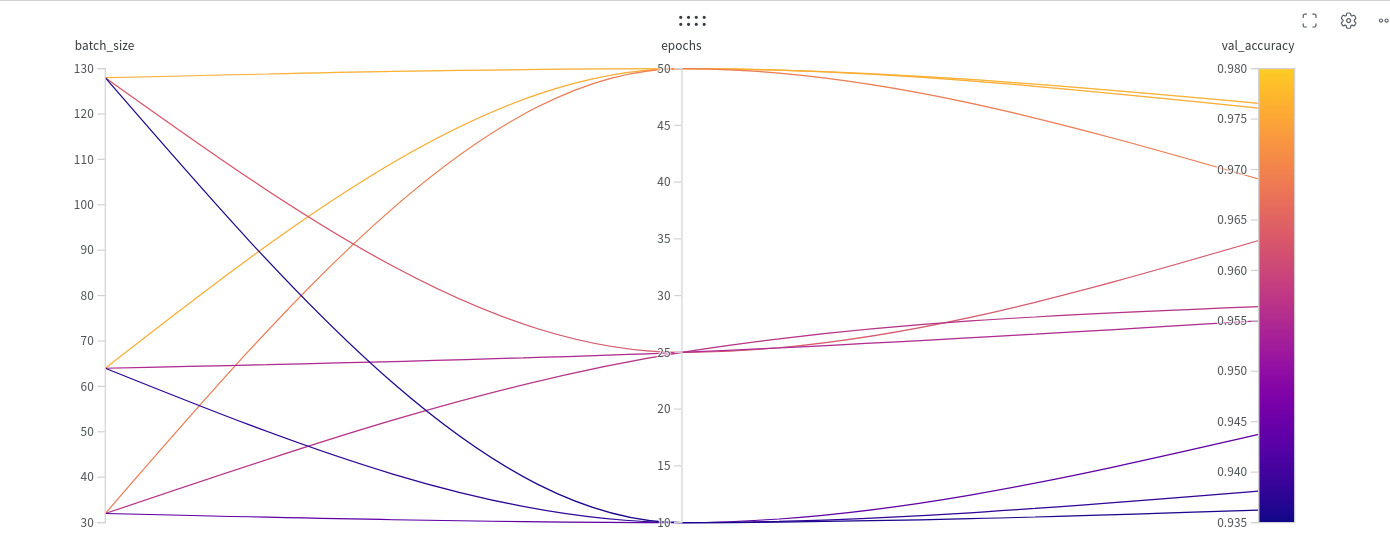

Seems like a batch size of 128 with 50 epochs is optimal for this problem

In [48]:
params = {
    'optimizer': 'adam',
    'loss': 'sparse_categorical_crossentropy',
    'metrics': ['accuracy']
}

In [49]:
report_mlp_tensor, y_pred_mlp_tensor, y_val_mlp_tensor = kfold_cross_validation_TF(create_model, X, y, params, epochs=50, batch_size=128, n_splits=10)

Fold 1


W0000 00:00:1740668849.586216    9803 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Validation accuracy: 0.9400187441424555
	Validation precision: 0.9409855143544957
	Validation recall: 0.9400187441424555
Fold 2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Validation accuracy: 0.9447047797563262
	Validation precision: 0.9467001307331676
	Validation recall: 0.9447047797563262
Fold 3
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Validation accuracy: 0.9390815370196813
	Validation precision: 0.9391747122599483
	Validation recall: 0.9390815370196813
Fold 4
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
	Validation accuracy: 0.925891181988743
	Validation precision: 0.9278544522872044
	Validation recall: 0.925891181988743
Fold 5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
	Validation accuracy: 0.9390243902439024
	Validation precision: 0.9418355924699475
	Validation recall: 0.9390243902439024
Fold 6
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Validation accuracy: 0.9333958724202627
	Validation precision: 0.9339791247993358
	Validation recall: 0.9333958724202627


In [50]:
reports['MLP-Tensor'] = report_mlp_tensor
pprint(report_mlp_tensor)

{'accuracy': {'max': np.float64(0.950281425891182),
              'mean': np.float64(0.9373523635027281),
              'min': np.float64(0.9230769230769231)},
 'precision': {'max': np.float64(0.9511498486671569),
               'mean': np.float64(0.9386003794945399),
               'min': np.float64(0.9238374470534817)},
 'recall': {'max': np.float64(0.950281425891182),
            'mean': np.float64(0.9373523635027281),
            'min': np.float64(0.9230769230769231)}}


# LSTM TensorFlow

In [174]:
def create_model_lstm(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):

    model =  Sequential([

        # LSTMs require a 3D input in the form of (time steps (window_size), features per sample). The batch size is not required and is automatically set by Keras.
        Input(shape=(7, 9)),

        LSTM(100, activation='relu', return_sequences=True), # Keeping the return_sequences=True to stack multiple LSTMs
        BatchNormalization(),

        LSTM(50, activation='relu'),
        BatchNormalization(),

        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(100, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Since the LSTM needs the matrix of features for every timestep, it is necessary to recreate the sliding window ignoring the extra features and avoing the flattening of the window

In [172]:
window_size = 7
step_size = 1
X_lstm, y_lstm = create_sliding_windows(data, window_size, step_size, output_3d=True) # This will create the sliding windows with a 3D X and 1D y_lstm
X_lstm.shape, y_lstm.shape

((10663, 7, 9), (10663,))

In [175]:
report_lstm, y_pred_lstm, y_val_lstm = kfold_cross_validation_TF(create_model_lstm, X_lstm, y_lstm, params, epochs=50, batch_size=128, n_splits=10)

Fold 1
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
	Validation accuracy: 0.9821930646672915
	Validation precision: 0.9825058843882618
	Validation recall: 0.9821930646672915
Fold 2
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
	Validation accuracy: 0.9681349578256795
	Validation precision: 0.96888527317891
	Validation recall: 0.9681349578256795
Fold 3
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
	Validation accuracy: 0.9765698219306467
	Validation precision: 0.9768870615364562
	Validation recall: 0.9765698219306467
Fold 4
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
	Validation accuracy: 0.9859287054409006
	Validation precision: 0.9861808453044347
	Validation recall: 0.9859287054409006
Fold 5
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
	Validation accuracy: 0.9455909943714822
	Validation precision: 0.9510425600911804
	Validation recall: 0.9455909943714822
Fold 6
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
	Validation accuracy: 0.9455909943714822
	Validation precision: 0.9505562403423984
	Validation recall: 0.945590

In [203]:
reports['LSTM'] = report_lstm
pprint(report_lstm)

{'accuracy': {'max': np.float64(0.9859287054409006),
              'mean': np.float64(0.9653914729977089),
              'min': np.float64(0.9418386491557224)},
 'precision': {'max': np.float64(0.9861808453044347),
               'mean': np.float64(0.96760681161996),
               'min': np.float64(0.945926030092369)},
 'recall': {'max': np.float64(0.9859287054409006),
            'mean': np.float64(0.9653914729977089),
            'min': np.float64(0.9418386491557224)}}


# Comparing Results

In [51]:
def compare_models(models_metrics):
    # Convert to DataFrame
    data = []
    for model, metrics in models_metrics.items():
        for metric, values in metrics.items():
            for stat, value in values.items():
                data.append([model, metric, stat, value])

    df = pd.DataFrame(data, columns=["Model", "Metric", "Stat", "Value"])

    # Pivot to create matrix format
    matrix_df = df.pivot(index=["Metric", "Stat"], columns="Model", values="Value")

    # Function to highlight the maximum value in each row
    def highlight_max(s):
        is_max = s == s.max()
        return ['font-weight: bold' if v else '' for v in is_max]

    # Apply the highlight function
    styled_matrix_df = matrix_df.style.apply(highlight_max, axis=1)

    # Display as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
    plt.title("Model Performance Metrics Heatmap")
    plt.show()

    # Print table format with highlighted max values
    display(styled_matrix_df)

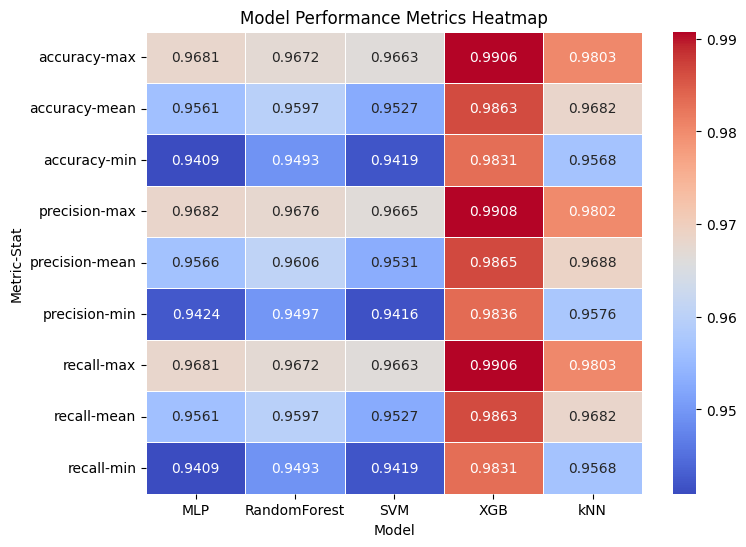

In [68]:
compare_models(reports)